In [34]:
# 3rd Party dependencies.
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision.transforms.v2 as transforms

from torch.utils.data import DataLoader
from tqdm import tqdm

# 1st Party dependencies.
from dataset.facades_dataset import FacadesDataset
from pix2pix.generator import UnetGenerator, GeneratorLoss
from pix2pix.discriminator import ConditionalDiscriminator, DiscriminatorLoss

%matplotlib inline

In [2]:
# Default transforms are noted in the original paper
# in paragraph 6.2 as "Random jitter".
# The experiment is called "Cityscapes labels→photo".
train_transforms = transforms.Compose([
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True),
    # Resizing the 256×256 input images to 286×286.
    transforms.Resize((286, 286)), 
    # Randomly cropping back to size 256×256.
    transforms.RandomCrop(256),
    # Mirroring.
    transforms.RandomHorizontalFlip(),
])

default_transforms = transforms.Compose([
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True),
])

In [3]:
facades_train_dataset = FacadesDataset(root_dir='dataset/facades', split='train', transformations=train_transforms)
facades_test_dataset = FacadesDataset(root_dir='dataset/facades', split='test', transformations=default_transforms)
facades_val_dataset = FacadesDataset(root_dir='dataset/facades', split='val', transformations=default_transforms)

train_dataloader = DataLoader(facades_train_dataset, batch_size=1, shuffle=True)

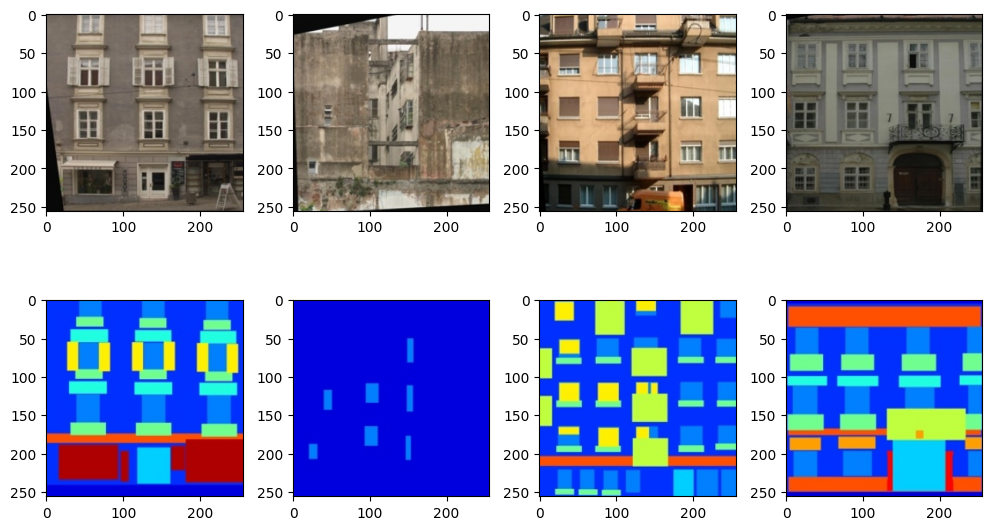

In [40]:
def visualise_dataset(dataset, indexes):
    figure, ax = plt.subplots(nrows=2, ncols=len(indexes), figsize=(10, 6))
    
    for i, idx in enumerate(indexes):
        image, label = dataset[idx]
        image = np.transpose(image.numpy(), (1,2,0))
        label = np.transpose(label.numpy(), (1,2,0))
        
        ax[0, i].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        ax[1, i].imshow(cv2.cvtColor(label, cv2.COLOR_BGR2RGB))
    plt.tight_layout(pad=1)
    plt.show()    

visualise_dataset(facades_train_dataset, np.random.choice(range(len(facades_train_dataset)), 4))

In [5]:
# Setup.
device = ('cuda' if torch.cuda.is_available() else 'cpu')
learning_rate = 0.0002
epochs = 200

generator = UnetGenerator().to(device)
discriminator = ConditionalDiscriminator().to(device)

# optimizers
generator_optimizer = torch.optim.Adam(generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))

# loss functions
generator_loss = GeneratorLoss(alpha=100)
discriminator_loss = DiscriminatorLoss()

generator_history = []
discriminator_history = []

for epoch in range(epochs):

    generator_losses = []
    discriminator_losses = []

    for real, condition in tqdm(train_dataloader):        
        condition = condition.to(device)
        real = real.to(device)

        # Generator's loss.
        fake = generator(condition)
        fake_pred = discriminator(fake, condition)
        gl = generator_loss(fake, real, fake_pred)

        # Discriminator's loss.
        fake = generator(condition).detach()
        fake_pred = discriminator(fake, condition)
        real_pred = discriminator(real, condition)
        dl = discriminator_loss(fake_pred, real_pred)

        # Generator's params update.
        generator_optimizer.zero_grad()
        gl.backward()
        generator_optimizer.step()

        # Discriminator's params update.
        discriminator_optimizer.zero_grad()
        dl.backward()
        discriminator_optimizer.step()

        generator_losses.append(gl.item())
        discriminator_losses.append(dl.item())

    epoch_g_loss = np.mean(generator_losses)
    epoch_d_loss = np.mean(discriminator_losses)
    
    generator_history.append(epoch_g_loss)
    discriminator_history.append(epoch_d_loss)

    print('Epoch:', epoch, 'generator loss:', epoch_g_loss, 'discriminator loss:', epoch_d_loss)

    torch.save(generator.state_dict(), f"generator-{epoch:03d}-{epoch_g_loss:.3f}.pt")
    torch.save(discriminator.state_dict(), f"discriminator-{epoch:03d}-{epoch_g_loss:.3f}.pt")

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:26<00:00,  4.61it/s]


Epoch: 0 generator loss: 23.927708230018617 discriminator loss: 0.17700482467014808


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:27<00:00,  4.58it/s]


Epoch: 1 generator loss: 24.726749086380003 discriminator loss: 0.004634421737428056


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:26<00:00,  4.61it/s]


Epoch: 2 generator loss: 22.30340276002884 discriminator loss: 0.19421491329208948


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:27<00:00,  4.55it/s]


Epoch: 3 generator loss: 23.51531307220459 discriminator loss: 0.03605840798205463


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:27<00:00,  4.59it/s]


Epoch: 4 generator loss: 24.538644490242003 discriminator loss: 0.0011784466535027605


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:28<00:00,  4.54it/s]


Epoch: 5 generator loss: 24.371002855300905 discriminator loss: 0.030296655486345116


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:28<00:00,  4.53it/s]


Epoch: 6 generator loss: 25.244332442283632 discriminator loss: 0.0015195640051751979


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:28<00:00,  4.53it/s]


Epoch: 7 generator loss: 25.579351830482484 discriminator loss: 0.0009233111130743055


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:27<00:00,  4.59it/s]


Epoch: 8 generator loss: 23.211446158885956 discriminator loss: 0.16521454951714987


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:28<00:00,  4.53it/s]


Epoch: 9 generator loss: 22.69514845132828 discriminator loss: 0.16419466773528257


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:28<00:00,  4.50it/s]


Epoch: 10 generator loss: 22.25323931694031 discriminator loss: 0.17654850702077965


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:28<00:00,  4.53it/s]


Epoch: 11 generator loss: 21.969866704940795 discriminator loss: 0.17883547863137209


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:28<00:00,  4.54it/s]


Epoch: 12 generator loss: 21.85924024105072 discriminator loss: 0.17687046344799456


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:26<00:00,  4.63it/s]


Epoch: 13 generator loss: 22.107658483982085 discriminator loss: 0.1346043815932353


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:27<00:00,  4.58it/s]


Epoch: 14 generator loss: 21.862335989475252 discriminator loss: 0.17734880919597346


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:27<00:00,  4.58it/s]


Epoch: 15 generator loss: 21.245059535503387 discriminator loss: 0.19819262091070414


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:29<00:00,  4.47it/s]


Epoch: 16 generator loss: 21.80650762319565 discriminator loss: 0.14131871306002722


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:29<00:00,  4.47it/s]


Epoch: 17 generator loss: 21.96303480863571 discriminator loss: 0.14233150529296837


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:27<00:00,  4.57it/s]


Epoch: 18 generator loss: 21.59836595773697 discriminator loss: 0.14060701668262482


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:27<00:00,  4.57it/s]


Epoch: 19 generator loss: 21.344004130363466 discriminator loss: 0.17117885214858689


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:28<00:00,  4.54it/s]


Epoch: 20 generator loss: 21.698754856586458 discriminator loss: 0.1450015793077182


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:28<00:00,  4.52it/s]


Epoch: 21 generator loss: 21.626914937496185 discriminator loss: 0.1244941070151981


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:28<00:00,  4.52it/s]


Epoch: 22 generator loss: 21.597024796009062 discriminator loss: 0.1676475551794283


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:28<00:00,  4.52it/s]


Epoch: 23 generator loss: 21.490217785835267 discriminator loss: 0.14481366504274773


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:28<00:00,  4.52it/s]


Epoch: 24 generator loss: 21.35255162715912 discriminator loss: 0.23151284033287084


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:28<00:00,  4.52it/s]


Epoch: 25 generator loss: 20.945286605358124 discriminator loss: 0.19979095776216127


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:28<00:00,  4.52it/s]


Epoch: 26 generator loss: 21.422997388839722 discriminator loss: 0.16883599900465923


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:29<00:00,  4.49it/s]


Epoch: 27 generator loss: 21.50677596092224 discriminator loss: 0.16801562412976637


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:29<00:00,  4.46it/s]


Epoch: 28 generator loss: 22.12402072906494 discriminator loss: 0.1709942662715912


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:29<00:00,  4.46it/s]


Epoch: 29 generator loss: 21.50134042739868 discriminator loss: 0.17558858299569693


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:29<00:00,  4.46it/s]


Epoch: 30 generator loss: 22.163246524333953 discriminator loss: 0.14359075520449552


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:29<00:00,  4.46it/s]


Epoch: 31 generator loss: 21.85649717092514 discriminator loss: 0.14839293138560605


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:30<00:00,  4.42it/s]


Epoch: 32 generator loss: 21.931944937705993 discriminator loss: 0.15684516045032068


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:31<00:00,  4.39it/s]


Epoch: 33 generator loss: 21.690809285640718 discriminator loss: 0.17091905142005998


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:32<00:00,  4.31it/s]


Epoch: 34 generator loss: 21.61054135799408 discriminator loss: 0.14348259551043158


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:32<00:00,  4.32it/s]


Epoch: 35 generator loss: 22.1795849776268 discriminator loss: 0.14161651048802015


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:32<00:00,  4.34it/s]


Epoch: 36 generator loss: 21.58042648553848 discriminator loss: 0.15229276735975872


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:30<00:00,  4.41it/s]


Epoch: 37 generator loss: 21.76587928056717 discriminator loss: 0.1405716886096343


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:28<00:00,  4.50it/s]


Epoch: 38 generator loss: 21.351426470279694 discriminator loss: 0.18568094371032204


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:32<00:00,  4.34it/s]


Epoch: 39 generator loss: 21.697605276107787 discriminator loss: 0.12596743955335113


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:32<00:00,  4.32it/s]


Epoch: 40 generator loss: 21.59483006477356 discriminator loss: 0.16351240336196496


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:29<00:00,  4.49it/s]


Epoch: 41 generator loss: 21.845823509693147 discriminator loss: 0.16377074739313685


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:29<00:00,  4.46it/s]


Epoch: 42 generator loss: 21.936699278354645 discriminator loss: 0.13239077791789897


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:29<00:00,  4.45it/s]


Epoch: 43 generator loss: 21.83058554172516 discriminator loss: 0.17513262733700685


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:32<00:00,  4.34it/s]


Epoch: 44 generator loss: 21.540261878967286 discriminator loss: 0.129816419268318


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:30<00:00,  4.44it/s]


Epoch: 45 generator loss: 21.712454624176026 discriminator loss: 0.12445798892498715


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:32<00:00,  4.32it/s]


Epoch: 46 generator loss: 21.43790496826172 discriminator loss: 0.15623223686488927


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:31<00:00,  4.39it/s]


Epoch: 47 generator loss: 21.550901670455932 discriminator loss: 0.17194222700403772


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:29<00:00,  4.46it/s]


Epoch: 48 generator loss: 22.180284054279326 discriminator loss: 0.11783704768473399


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:29<00:00,  4.49it/s]


Epoch: 49 generator loss: 21.52939256429672 discriminator loss: 0.13365033979142027


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:30<00:00,  4.43it/s]


Epoch: 50 generator loss: 21.440523812770845 discriminator loss: 0.13799729229343938


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:29<00:00,  4.48it/s]


Epoch: 51 generator loss: 22.27590994358063 discriminator loss: 0.14342627012432785


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:29<00:00,  4.45it/s]


Epoch: 52 generator loss: 22.607099928855895 discriminator loss: 0.12313357706792885


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:30<00:00,  4.40it/s]


Epoch: 53 generator loss: 21.54662122488022 discriminator loss: 0.19057186577352694


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:32<00:00,  4.33it/s]


Epoch: 54 generator loss: 21.62918438196182 discriminator loss: 0.13407244822563372


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:31<00:00,  4.37it/s]


Epoch: 55 generator loss: 21.414970626831053 discriminator loss: 0.1416041239189508


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:29<00:00,  4.47it/s]


Epoch: 56 generator loss: 21.689517438411713 discriminator loss: 0.16886498909734654


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:31<00:00,  4.39it/s]


Epoch: 57 generator loss: 21.855049226284027 discriminator loss: 0.13119760138710262


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:32<00:00,  4.34it/s]


Epoch: 58 generator loss: 21.12403736591339 discriminator loss: 0.19170376530120847


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:32<00:00,  4.32it/s]


Epoch: 59 generator loss: 20.938144404888153 discriminator loss: 0.16582370781892677


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:30<00:00,  4.42it/s]


Epoch: 60 generator loss: 20.87211494207382 discriminator loss: 0.14870812468208897


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:31<00:00,  4.35it/s]


Epoch: 61 generator loss: 20.77181355714798 discriminator loss: 0.1577227706144913


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:31<00:00,  4.38it/s]


Epoch: 62 generator loss: 20.76029463291168 discriminator loss: 0.17376690112781945


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:33<00:00,  4.27it/s]


Epoch: 63 generator loss: 20.799038860797882 discriminator loss: 0.1676251929535647


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:32<00:00,  4.31it/s]


Epoch: 64 generator loss: 20.8298805308342 discriminator loss: 0.17004862156944


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:33<00:00,  4.29it/s]


Epoch: 65 generator loss: 20.532766695022584 discriminator loss: 0.17242612673522673


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:32<00:00,  4.34it/s]


Epoch: 66 generator loss: 20.795272254943846 discriminator loss: 0.14752853882688213


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:29<00:00,  4.47it/s]


Epoch: 67 generator loss: 20.296331841945648 discriminator loss: 0.16416553113551344


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:29<00:00,  4.48it/s]


Epoch: 68 generator loss: 20.890079560279847 discriminator loss: 0.16919522697993672


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:29<00:00,  4.48it/s]


Epoch: 69 generator loss: 20.907003860473633 discriminator loss: 0.15652889923621843


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:29<00:00,  4.48it/s]


Epoch: 70 generator loss: 20.802447304725646 discriminator loss: 0.15710907670792948


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:29<00:00,  4.45it/s]


Epoch: 71 generator loss: 20.795238609313966 discriminator loss: 0.1243471036171104


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:28<00:00,  4.50it/s]


Epoch: 72 generator loss: 20.90419195652008 discriminator loss: 0.16015348074535724


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:29<00:00,  4.47it/s]


Epoch: 73 generator loss: 20.79394835472107 discriminator loss: 0.16574091668520852


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:29<00:00,  4.48it/s]


Epoch: 74 generator loss: 20.988237779140473 discriminator loss: 0.15098235299068619


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:29<00:00,  4.48it/s]


Epoch: 75 generator loss: 21.523046872615815 discriminator loss: 0.12113499789789785


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:29<00:00,  4.48it/s]


Epoch: 76 generator loss: 21.172228128910064 discriminator loss: 0.15456810605257487


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:29<00:00,  4.48it/s]


Epoch: 77 generator loss: 20.638585693836212 discriminator loss: 0.1841465768602211


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:30<00:00,  4.42it/s]


Epoch: 78 generator loss: 20.51101764202118 discriminator loss: 0.14071327045050566


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:32<00:00,  4.32it/s]


Epoch: 79 generator loss: 20.73421331167221 discriminator loss: 0.15784976504568476


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:33<00:00,  4.29it/s]


Epoch: 80 generator loss: 20.778219838142395 discriminator loss: 0.150105498124758


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:33<00:00,  4.30it/s]


Epoch: 81 generator loss: 20.379982454776766 discriminator loss: 0.1903906834698864


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:34<00:00,  4.25it/s]


Epoch: 82 generator loss: 20.151781232357024 discriminator loss: 0.21268595606612506


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:32<00:00,  4.31it/s]


Epoch: 83 generator loss: 19.53461860895157 discriminator loss: 0.20777464926475658


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:33<00:00,  4.28it/s]


Epoch: 84 generator loss: 19.556335387229918 discriminator loss: 0.1869227300529019


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:31<00:00,  4.36it/s]


Epoch: 85 generator loss: 19.70888296365738 discriminator loss: 0.1639404566916346


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:31<00:00,  4.35it/s]


Epoch: 86 generator loss: 19.231165030002593 discriminator loss: 0.22080572989158098


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:31<00:00,  4.37it/s]


Epoch: 87 generator loss: 19.191823749542237 discriminator loss: 0.18087082051613834


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:33<00:00,  4.29it/s]


Epoch: 88 generator loss: 19.24215394496918 discriminator loss: 0.22045197806859507


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:32<00:00,  4.30it/s]


Epoch: 89 generator loss: 19.341249401569367 discriminator loss: 0.1818558159036911


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:32<00:00,  4.32it/s]


Epoch: 90 generator loss: 19.329128296375274 discriminator loss: 0.17202826057444326


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:32<00:00,  4.31it/s]


Epoch: 91 generator loss: 19.140251982212067 discriminator loss: 0.19033349934528815


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:33<00:00,  4.29it/s]


Epoch: 92 generator loss: 19.11537570953369 discriminator loss: 0.18670624220234458


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:35<00:00,  4.18it/s]


Epoch: 93 generator loss: 19.146658833026887 discriminator loss: 0.2050571263238089


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:33<00:00,  4.26it/s]


Epoch: 94 generator loss: 19.197808032035827 discriminator loss: 0.18086323017196265


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:32<00:00,  4.33it/s]


Epoch: 95 generator loss: 18.87991260766983 discriminator loss: 0.21049164108862897


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:32<00:00,  4.31it/s]


Epoch: 96 generator loss: 19.037975718975066 discriminator loss: 0.17052854377543553


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:30<00:00,  4.44it/s]


Epoch: 97 generator loss: 19.241840031147003 discriminator loss: 0.18694617065717467


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:34<00:00,  4.22it/s]


Epoch: 98 generator loss: 18.83268573284149 discriminator loss: 0.19305213452957104


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:34<00:00,  4.23it/s]


Epoch: 99 generator loss: 18.905295932292937 discriminator loss: 0.17963546967774163


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:31<00:00,  4.36it/s]


Epoch: 100 generator loss: 18.77743658065796 discriminator loss: 0.1986670540520572


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:33<00:00,  4.28it/s]


Epoch: 101 generator loss: 18.75144498348236 discriminator loss: 0.19044104278975282


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:33<00:00,  4.30it/s]


Epoch: 102 generator loss: 18.679300599098205 discriminator loss: 0.21756271699705393


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:32<00:00,  4.33it/s]


Epoch: 103 generator loss: 18.86115861415863 discriminator loss: 0.17839124130405254


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:31<00:00,  4.39it/s]


Epoch: 104 generator loss: 18.566951599121094 discriminator loss: 0.1920885199663462


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:32<00:00,  4.34it/s]


Epoch: 105 generator loss: 18.56755707502365 discriminator loss: 0.19156331694597611


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:31<00:00,  4.36it/s]


Epoch: 106 generator loss: 18.415134646892547 discriminator loss: 0.17898096857650672


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:31<00:00,  4.37it/s]


Epoch: 107 generator loss: 18.612394409179686 discriminator loss: 0.1774898026091978


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:32<00:00,  4.30it/s]


Epoch: 108 generator loss: 18.37740142583847 discriminator loss: 0.2085325223117252


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:33<00:00,  4.29it/s]


Epoch: 109 generator loss: 18.53317740678787 discriminator loss: 0.19571172115785884


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:31<00:00,  4.36it/s]


Epoch: 110 generator loss: 18.058636343479158 discriminator loss: 0.19975125372729963


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:35<00:00,  4.21it/s]


Epoch: 111 generator loss: 18.222389051914217 discriminator loss: 0.23830544641605228


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:33<00:00,  4.26it/s]


Epoch: 112 generator loss: 18.029359726905824 discriminator loss: 0.1927331014257652


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:31<00:00,  4.35it/s]


Epoch: 113 generator loss: 18.05059134721756 discriminator loss: 0.16785158652084647


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:31<00:00,  4.36it/s]


Epoch: 114 generator loss: 17.962066292762756 discriminator loss: 0.20089804794435623


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:31<00:00,  4.35it/s]


Epoch: 115 generator loss: 18.305630795955658 discriminator loss: 0.184613137798151


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:31<00:00,  4.36it/s]


Epoch: 116 generator loss: 17.98526029586792 discriminator loss: 0.17891897381690797


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:31<00:00,  4.37it/s]


Epoch: 117 generator loss: 17.854953174591063 discriminator loss: 0.2534695328742964


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:31<00:00,  4.38it/s]


Epoch: 118 generator loss: 17.85545472621918 discriminator loss: 0.17818969979300164


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:31<00:00,  4.37it/s]


Epoch: 119 generator loss: 18.133165066242217 discriminator loss: 0.18707621350651607


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:31<00:00,  4.38it/s]


Epoch: 120 generator loss: 18.042698056697844 discriminator loss: 0.16795467514006304


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:31<00:00,  4.37it/s]


Epoch: 121 generator loss: 17.77179730415344 discriminator loss: 0.19753574235044652


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:31<00:00,  4.36it/s]


Epoch: 122 generator loss: 17.91259120941162 discriminator loss: 0.220511843150598


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:31<00:00,  4.37it/s]


Epoch: 123 generator loss: 17.869549298286437 discriminator loss: 0.1824811947645503


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:30<00:00,  4.40it/s]


Epoch: 124 generator loss: 17.631065440177917 discriminator loss: 0.17629226896242473


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:30<00:00,  4.41it/s]


Epoch: 125 generator loss: 17.562139878273012 discriminator loss: 0.23157013838936108


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:33<00:00,  4.28it/s]


Epoch: 126 generator loss: 17.583808379173277 discriminator loss: 0.1850779803993646


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:33<00:00,  4.28it/s]


Epoch: 127 generator loss: 17.79430368423462 discriminator loss: 0.19459673990990267


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:34<00:00,  4.24it/s]


Epoch: 128 generator loss: 17.45053835391998 discriminator loss: 0.21922516569436992


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:34<00:00,  4.25it/s]


Epoch: 129 generator loss: 17.54940174818039 discriminator loss: 0.2026828049463802


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:31<00:00,  4.35it/s]


Epoch: 130 generator loss: 17.562720425128937 discriminator loss: 0.17554837710165885


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:31<00:00,  4.36it/s]


Epoch: 131 generator loss: 17.486273069381713 discriminator loss: 0.20824606873757148


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:32<00:00,  4.30it/s]


Epoch: 132 generator loss: 17.65694667816162 discriminator loss: 0.18285816234711091


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:36<00:00,  4.14it/s]


Epoch: 133 generator loss: 17.691624352931978 discriminator loss: 0.16333981479067006


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:34<00:00,  4.24it/s]


Epoch: 134 generator loss: 17.280941591262817 discriminator loss: 0.2360214003053261


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:33<00:00,  4.28it/s]


Epoch: 135 generator loss: 17.226178686618805 discriminator loss: 0.1782464847168012


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:32<00:00,  4.33it/s]


Epoch: 136 generator loss: 18.574807963371278 discriminator loss: 0.1703051530526136


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:32<00:00,  4.30it/s]


Epoch: 137 generator loss: 17.498714220523834 discriminator loss: 0.19611451590433718


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:34<00:00,  4.24it/s]


Epoch: 138 generator loss: 17.176039204597473 discriminator loss: 0.216891584637051


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:33<00:00,  4.30it/s]


Epoch: 139 generator loss: 17.45842449903488 discriminator loss: 0.17884171574103674


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:33<00:00,  4.27it/s]


Epoch: 140 generator loss: 17.55804428577423 discriminator loss: 0.19477203333197393


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:32<00:00,  4.34it/s]


Epoch: 141 generator loss: 17.363454871177673 discriminator loss: 0.1640724691201467


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:33<00:00,  4.27it/s]


Epoch: 142 generator loss: 17.317729108333587 discriminator loss: 0.18699630297342082


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:32<00:00,  4.31it/s]


Epoch: 143 generator loss: 17.208372082710266 discriminator loss: 0.20118773631038495


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:32<00:00,  4.33it/s]


Epoch: 144 generator loss: 17.412223875522614 discriminator loss: 0.18969795297802194


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:32<00:00,  4.32it/s]


Epoch: 145 generator loss: 17.156629548072814 discriminator loss: 0.17420374179491774


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:32<00:00,  4.34it/s]


Epoch: 146 generator loss: 16.857920076847076 discriminator loss: 0.2449920403760916


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:32<00:00,  4.34it/s]


Epoch: 147 generator loss: 16.76059296131134 discriminator loss: 0.2020492538943654


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:33<00:00,  4.29it/s]


Epoch: 148 generator loss: 17.274030163288117 discriminator loss: 0.14900317503459518


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:32<00:00,  4.31it/s]


Epoch: 149 generator loss: 17.077757852077482 discriminator loss: 0.2041476111819793


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:31<00:00,  4.38it/s]


Epoch: 150 generator loss: 16.96394936800003 discriminator loss: 0.21650762005534488


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:31<00:00,  4.36it/s]


Epoch: 151 generator loss: 16.857850229740144 discriminator loss: 0.20744264311739244


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:31<00:00,  4.39it/s]


Epoch: 152 generator loss: 16.65731033563614 discriminator loss: 0.18994055188559286


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:31<00:00,  4.39it/s]


Epoch: 153 generator loss: 16.768513283729554 discriminator loss: 0.21764712517597218


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:31<00:00,  4.38it/s]


Epoch: 154 generator loss: 16.710491020679473 discriminator loss: 0.22496296063047339


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:31<00:00,  4.37it/s]


Epoch: 155 generator loss: 16.647955927848816 discriminator loss: 0.18649051188898738


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:30<00:00,  4.41it/s]


Epoch: 156 generator loss: 16.81270299434662 discriminator loss: 0.17891928809680394


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:31<00:00,  4.38it/s]


Epoch: 157 generator loss: 16.759203763008117 discriminator loss: 0.19734769755756132


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:32<00:00,  4.30it/s]


Epoch: 158 generator loss: 16.849902353286744 discriminator loss: 0.1711948445843882


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:32<00:00,  4.33it/s]


Epoch: 159 generator loss: 16.82402553319931 discriminator loss: 0.20568799818698608


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:32<00:00,  4.31it/s]


Epoch: 160 generator loss: 16.821296701431276 discriminator loss: 0.16091028955837827


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:32<00:00,  4.30it/s]


Epoch: 161 generator loss: 16.50327648639679 discriminator loss: 0.261380351826956


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:33<00:00,  4.28it/s]


Epoch: 162 generator loss: 16.456819665431976 discriminator loss: 0.18682736756672966


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:32<00:00,  4.31it/s]


Epoch: 163 generator loss: 16.57375622987747 discriminator loss: 0.22687816313013173


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:32<00:00,  4.33it/s]


Epoch: 164 generator loss: 16.52520087003708 discriminator loss: 0.17446881696945638


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:33<00:00,  4.29it/s]


Epoch: 165 generator loss: 16.486811695098876 discriminator loss: 0.22131123349143308


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:33<00:00,  4.29it/s]


Epoch: 166 generator loss: 16.87619497537613 discriminator loss: 0.15426527760078898


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:32<00:00,  4.33it/s]


Epoch: 167 generator loss: 16.573300058841706 discriminator loss: 0.20694568116479786


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:31<00:00,  4.36it/s]


Epoch: 168 generator loss: 16.390233364105224 discriminator loss: 0.23908722016509273


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:31<00:00,  4.36it/s]


Epoch: 169 generator loss: 16.30504356622696 discriminator loss: 0.21530078288633375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:33<00:00,  4.27it/s]


Epoch: 170 generator loss: 16.529110543727874 discriminator loss: 0.1615708597383491


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:33<00:00,  4.26it/s]


Epoch: 171 generator loss: 16.9405880177021 discriminator loss: 0.14847508175091206


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:34<00:00,  4.24it/s]


Epoch: 172 generator loss: 16.330550031661986 discriminator loss: 0.2151368788300897


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:34<00:00,  4.24it/s]


Epoch: 173 generator loss: 16.44577251911163 discriminator loss: 0.17336273351047565


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:31<00:00,  4.39it/s]


Epoch: 174 generator loss: 16.230973205566407 discriminator loss: 0.19057204345663195


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:33<00:00,  4.29it/s]


Epoch: 175 generator loss: 16.551869611740113 discriminator loss: 0.16090485535212792


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:31<00:00,  4.36it/s]


Epoch: 176 generator loss: 16.380269463062287 discriminator loss: 0.22937315454284543


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:32<00:00,  4.31it/s]


Epoch: 177 generator loss: 16.065982232093813 discriminator loss: 0.23499329775338992


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:32<00:00,  4.32it/s]


Epoch: 178 generator loss: 16.174818918704986 discriminator loss: 0.16361164782720153


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:33<00:00,  4.29it/s]


Epoch: 179 generator loss: 16.344997465610504 discriminator loss: 0.20646598029758023


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:31<00:00,  4.35it/s]


Epoch: 180 generator loss: 16.24926679611206 discriminator loss: 0.18770044895994942


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:30<00:00,  4.40it/s]


Epoch: 181 generator loss: 16.49840076446533 discriminator loss: 0.17808596820294043


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:31<00:00,  4.35it/s]


Epoch: 182 generator loss: 16.637964491844176 discriminator loss: 0.16493333639024058


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:31<00:00,  4.38it/s]


Epoch: 183 generator loss: 15.915505048036575 discriminator loss: 0.243871010159055


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:31<00:00,  4.35it/s]


Epoch: 184 generator loss: 16.20408425807953 discriminator loss: 0.19143844740756322


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:31<00:00,  4.39it/s]


Epoch: 185 generator loss: 16.103633956909178 discriminator loss: 0.20364203486489715


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:31<00:00,  4.38it/s]


Epoch: 186 generator loss: 16.14497020959854 discriminator loss: 0.17015076467592735


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:34<00:00,  4.22it/s]


Epoch: 187 generator loss: 16.128087599277496 discriminator loss: 0.19949592085395124


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:33<00:00,  4.29it/s]


Epoch: 188 generator loss: 16.08884456396103 discriminator loss: 0.19197951838141308


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:33<00:00,  4.29it/s]


Epoch: 189 generator loss: 16.210714247226715 discriminator loss: 0.18213712076500088


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:31<00:00,  4.38it/s]


Epoch: 190 generator loss: 16.223196151256563 discriminator loss: 0.21852752312464874


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:34<00:00,  4.22it/s]


Epoch: 191 generator loss: 15.81588996887207 discriminator loss: 0.2017094263169565


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:35<00:00,  4.18it/s]


Epoch: 192 generator loss: 15.805992727279664 discriminator loss: 0.1917410237820877


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:33<00:00,  4.29it/s]


Epoch: 193 generator loss: 16.28174758911133 discriminator loss: 0.15996551742427984


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:32<00:00,  4.34it/s]


Epoch: 194 generator loss: 16.192900393009186 discriminator loss: 0.20178256321625668


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:33<00:00,  4.29it/s]


Epoch: 195 generator loss: 16.121394455432892 discriminator loss: 0.2054786527401302


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:35<00:00,  4.19it/s]


Epoch: 196 generator loss: 15.646454222202301 discriminator loss: 0.20554250354645773


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:32<00:00,  4.34it/s]


Epoch: 197 generator loss: 16.007657370567323 discriminator loss: 0.17622649899232784


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:33<00:00,  4.29it/s]


Epoch: 198 generator loss: 16.02313345193863 discriminator loss: 0.19447820694724213


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:35<00:00,  4.19it/s]


Epoch: 199 generator loss: 16.043202617168426 discriminator loss: 0.17671851699817126


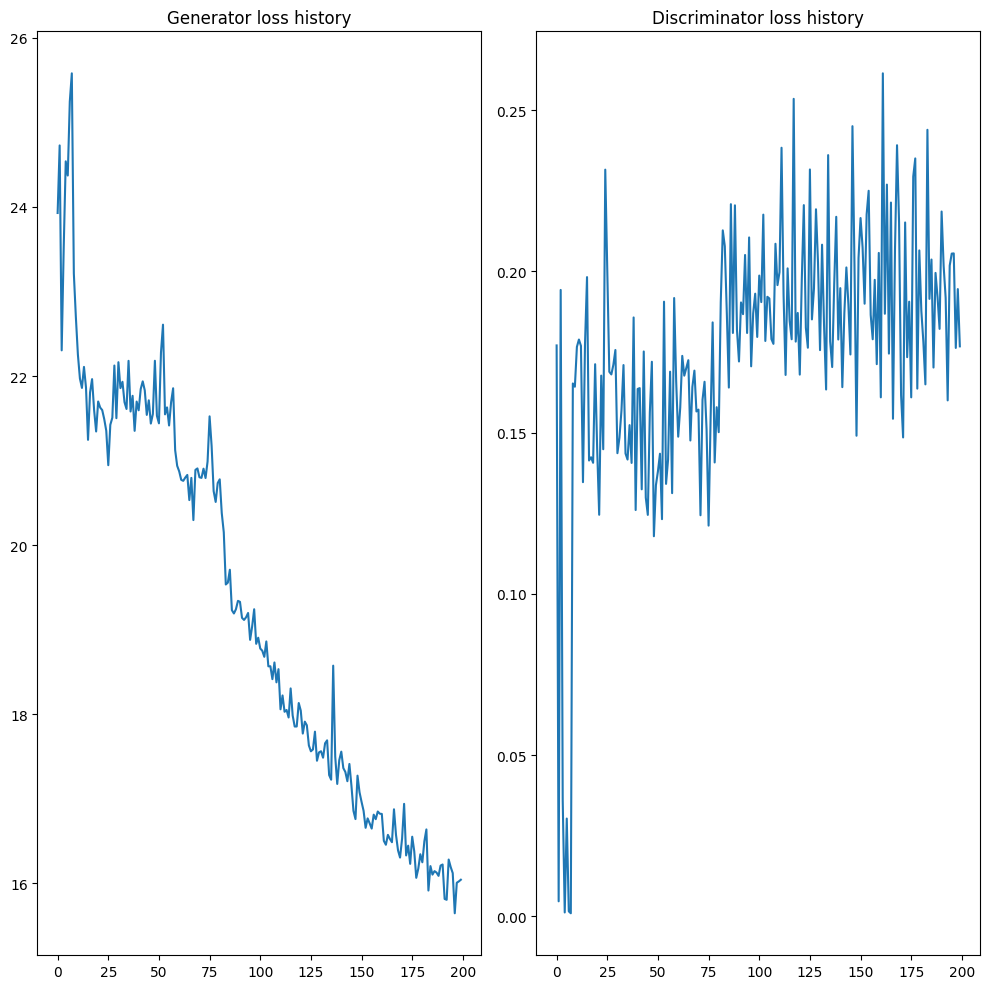

In [6]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))

ax[0].set_title("Generator loss history")
ax[0].plot(generator_history)

ax[1].set_title("Discriminator loss history")
ax[1].plot(discriminator_history)

plt.tight_layout()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


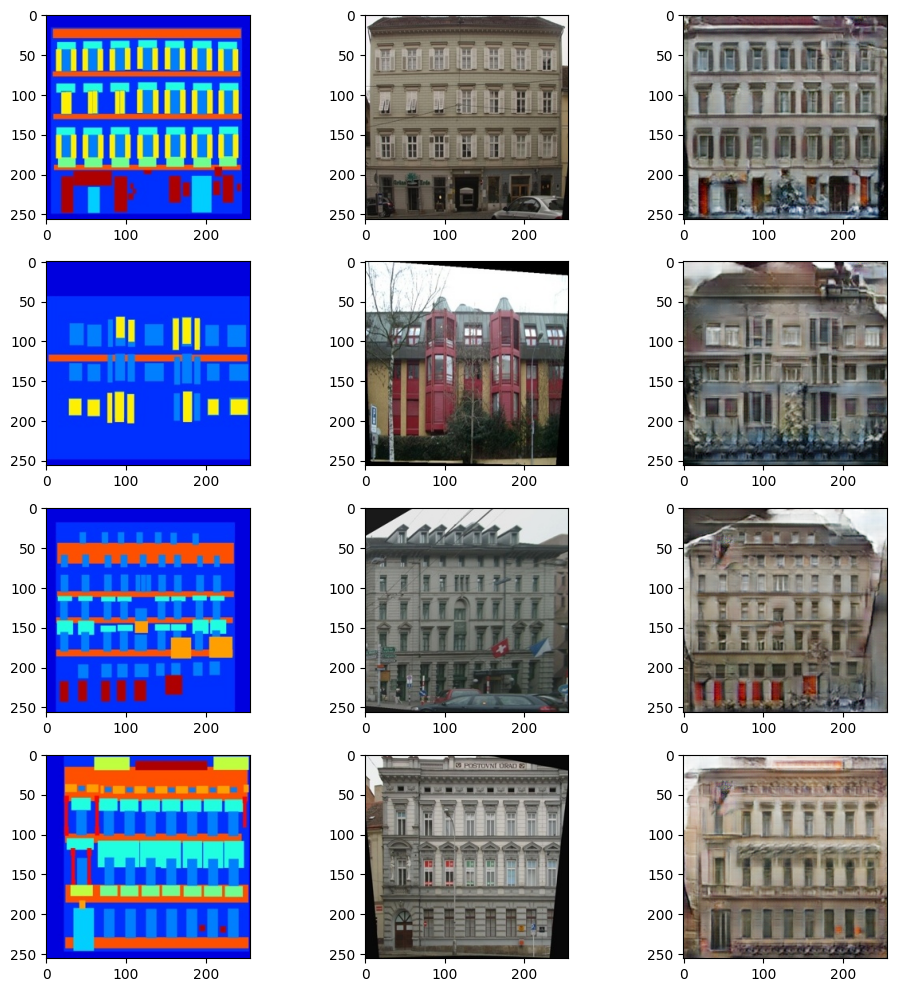

In [41]:
def visualise_inference(model_file, dataset, indexes):
    generator_model = UnetGenerator().to(device)
    generator_model.load_state_dict(torch.load(model_file))
    
    figure, ax = plt.subplots(nrows=len(indexes), ncols=3, figsize=(10, 10))
    
    for i, idx in enumerate(indexes):
        image, label = dataset[idx]

        input = torch.tensor(np.expand_dims(label, 0))
        fake = generator_model(input)
        fake = fake.detach().numpy()

        fake = np.transpose(fake[0], (1,2,0))
        image = np.transpose(image.numpy(), (1,2,0))
        label = np.transpose(label.numpy(), (1,2,0))

        ax[i, 0].imshow(cv2.cvtColor(label, cv2.COLOR_BGR2RGB))
        ax[i, 1].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        ax[i, 2].imshow(cv2.cvtColor(fake, cv2.COLOR_BGR2RGB))
    plt.tight_layout(pad=1)
    plt.show()    

visualise_inference('generator-197-16.008.pt', facades_val_dataset, np.random.choice(range(len(facades_val_dataset)), 4))